In [1]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import normalize
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [125]:
def pipeline(df, version=0):
    # 0.8658068783068783
    df_n = df.copy()
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: # 0.893320105820106
        col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df_train.Aspect.map(lambda x: x-180 if x > 180 else x+180) # np.abs(df.Aspect - 180)
        df_n['atan_aspect'] = np.arctan(df_n.norm_aspect)
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df_train.Elevation - df_train.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df_train.Elevation - df_train.Horizontal_Distance_To_Hydrology * .5
        
        df_n['F+R'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df_train.Horizontal_Distance_To_Fire_Points - df_train.Horizontal_Distance_To_Roadways)) 
    return df_n

def submit(model,version):
    global df_train
    df_train_c = pipeline(df_train.copy(),version)
    df_submit = pipeline(df_test.copy(),version)
    X, Y = df_train_c.drop(columns=['Cover_Type']).to_numpy(), df_train_c.Cover_Type.to_numpy()
    model.fit(X, Y)
    pred = model.predict(df_submit.to_numpy())
    final_df = df_test.copy()
    final_df['Cover_Type'] = pred
    return final_df[['Id','Cover_Type']]

In [94]:
df_train = pd.read_csv('train.csv')
df_train_norm = pipeline(df_train, version=3)


14

In [111]:
def soils(model):
    df_train_norm_copy = df_train_norm.copy()
    soils = ['Soil_Type' + str(i) for i in range(1,41) if i != 7]
    one_ind = list(df_train_norm_copy.columns).index('Soil_Type1')
    fort_ind = list(df_train_norm_copy.columns).index('Soil_Type40')
    df_train_norm_copy['Soil_Type'] = (df_train_norm_copy.iloc[:, one_ind:fort_ind] == 1).idxmax(1).str.replace('Soil_Type','').astype(float)
    #df_train_norm_copy.drop(columns=soils)
    return df_train_norm_copy

df_train_norm = soils(df_train_norm)

In [116]:
soils = ['Soil_Type' + str(i) for i in range(1,41) if i != 7]
df_train_norm.drop(columns=soils)

KeyError: "[('Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40')] not found in axis"

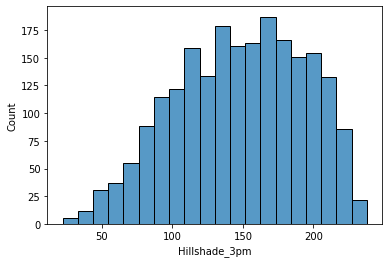

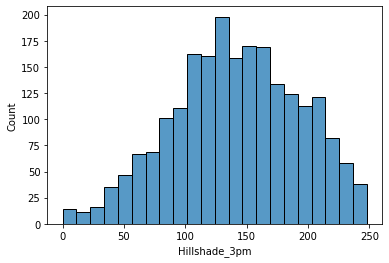

In [124]:
plt.figure()
df_one = df_train[df_train['Cover_Type'] == 6]

sn.histplot(data=df_one, x='Hillshade_3pm')

plt.figure()
df_two = df_train[df_train['Cover_Type'] == 3]
sn.histplot(data=df_two, x='Hillshade_3pm')

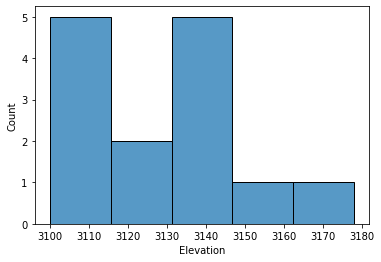

In [62]:
eb = df_one[df_one['E-bool1'] == 0]
sn.histplot(data=eb, x='Elevation')